In [14]:
# -*- coding: utf-8 -*-
'''
Sample script for solar array image classification

Author:       Kyle Bradbury, Ethan Swartzentruber
Date:         January 30, 2018
Organization: Duke University Energy Initiative
'''

'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
#from lib.plot_roc import plot_roc
import datetime
plt.close()

# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'

'''
Include the functions used for loading, preprocessing, features extraction, 
classification, and performance evaluation
'''

def load_data(dir_data, dir_labels, training=True):
    '''
    Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

def preprocess_and_extract_features(data):
    '''
    Preprocess data and extract features
    
    This is for anything you want to run between loading the data and calling fit.
    See the cv_performance_assessment code for how this is used.
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    #data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    #vectorized_data = data.reshape(data.shape[0],-1)
    
    
    return data

def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

'''
Function for producing a Kaggle submission
'''
def produce_submission(clf, fileName,test_features):
    # Load data, extract features, and train the classifier on the training data
    #training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    #training_features              = preprocess_and_extract_features(training_data)
    #clf.fit(training_features,training_labels)

    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
    #test_features  = preprocess_and_extract_features(test_data)
    test_scores    = clf.predict_proba(test_features)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv(fileName, columns=['id','score'], index=False)
    
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()



In [15]:
# Load the data
training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)

test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
# If you need training-data-dependent transformation, define variables here and reference them
# In the preprocessing function in the first cell.


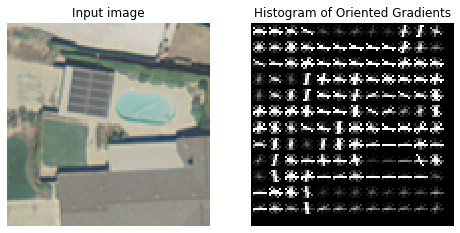

In [44]:
from skimage.feature import hog

fd, hog_image = hog(training_data[3], orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(training_data[3], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [110]:
hog_features=[]
for train in training_data:
    h = hog(train, orientations=9, pixels_per_cell=(10, 10),
                    cells_per_block=(1, 1), transform_sqrt=True, block_norm="L1")
    
    hog_features.append(h)


In [59]:
svmClassifier = svm.SVC(kernel='rbf', degree = 3, probability=True, C=1, gamma='scale')
#svmClassifier.fit(hog_features,training_labels)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [220]:
hog_test_features=[]
for test in test_data:
    h = hog(test, orientations=4, pixels_per_cell=(30, 30),
                    cells_per_block=(1, 1), transform_sqrt=True, block_norm="L1")
    
    hog_test_features.append(h)

In [226]:
# Construct classifier
clf_name = "SVM" # Used to name the submission file
clf = svm.SVC(kernel='rbf', probability=True,C=10, gamma='scale')
#clf.fit(hog_features,training_labels)

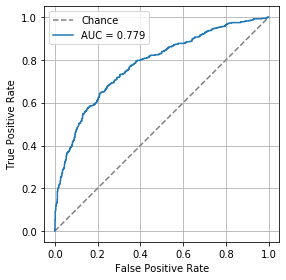

In [227]:
# Run cross-validation and check the roc curve

# Set parameters for the analysis
num_training_folds = 5

# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(np.array(hog_features),training_labels,num_training_folds,clf)

# Compute and plot the ROC curves
plot_roc(training_labels, prediction_scores)


(10,10) 6 c=1 = 0.795
(10,10) 4 c=1 = 0.792
(20,20) 6 c=1 =.0.786
(20,20) 4 c=1 = 0.784
(30,30) 9 c=1 = 0.79
(30,30) 6 c=1 = 0.785
(30,30) 6 c=1 = 0.785
(30,30) 4 c=1 = 0.781



In [17]:
## sift
import cv2
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

train_kp, train_desc = gen_sift_features(training_data[0])


AttributeError: module 'cv2' has no attribute 'xfeatures2d'

In [11]:
import cv2
s=cv2.SIFT()
#orb = cv2.ORB()
#kp1, des1 = orb.detectAndCompute(training_data[0],None)

AttributeError: module 'cv2' has no attribute 'SIFT'

In [121]:
last_score = pd.read_csv('submission_PCA_SVM_3C.csv')
last_score.score

0      0.187471
1      0.442942
2      0.268111
3      0.421540
4      0.447662
5      0.052512
6      0.733542
7      0.574101
8      0.223569
9      0.480948
10     0.211542
11     0.314695
12     0.120133
13     0.530655
14     0.280229
15     0.201133
16     0.297829
17     0.277184
18     0.393145
19     0.328319
20     0.135870
21     0.117586
22     0.253439
23     0.446188
24     0.300120
25     0.379421
26     0.348868
27     0.113237
28     0.193966
29     0.092049
         ...   
528    0.529254
529    0.347616
530    0.424577
531    0.206827
532    0.328111
533    0.091978
534    0.203334
535    0.208562
536    0.477918
537    0.248544
538    0.599040
539    0.805271
540    0.119830
541    0.248110
542    0.170144
543    0.180585
544    0.117881
545    0.083259
546    0.552345
547    0.253988
548    0.133277
549    0.512121
550    0.754463
551    0.645001
552    0.199484
553    0.152768
554    0.133171
555    0.527828
556    0.203827
557    0.289509
Name: score, Length: 558

In [133]:
score = clf.predict_proba(hog_test_features)

In [135]:
np.corrcoef(score[:,1], last_score.score)

array([[1.        , 0.51253368],
       [0.51253368, 1.        ]])

In [130]:
# Produce submission (by default is commented out)

time = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")
produce_submission(clf, clf_name+"_"+time+".csv",hog_test_features)